# Unsupervised anomaly detection (fraud) algorithm

This notebook has good example algorithms to do a forensic-type analysis, looking for anomalies in a dataset. We first do some data cleaning (exclusions, imputation, don't remove outliers - that's what we're looking for), then build variables that are designed to look for the kinds of anomalies we are interested in, in this case, unusual property valuations.

After we build the variables we know we have lots of correlations and too high dimensionality so we need to remove correlations and reduce dimensionality. Since we don't have a dependent variable the easiest useful thing to do is PCA. We z scale (always z scale before a PCA), do PCA, keep the top few PCs, then z scale again in order to make each retained PC equally important (optional step; only do this if you keep just a few PCs.).

We use two different anomaly detection (fraud) algorithms. The first just looks for outliers in the final scaled PC space using a Minkowski distance from the origin. The second method makes a simple autoencoder and the fraud score is then the reproduction error. It's important to note that each/either of these two methods would be a fine fraud score by itself.

Since we have two score and we don't really know which one is better we just average the two scores. To do this we replace the score with its rank order and then average the rank-ordered scores for our final score.

Finally we sort all the records by this final score and explore the top n records. To help the investigation we show which of the variables are driving these top scoring records with a heat map of the zscores of the variables, which can point the investigators to what's making the score high for these top scoring records.

This problem is an invented problem to demonstrate the process of building unsupervised fraud models. The data set is real and the invented problem is realistic. What's lacking the most is the ability to interact with domain experts in order to do proper exclusions and design good/appropriate variables.

The data can be found here: https://data.cityofnewyork.us/Housing-Development/Property-Valuation-and-Assessment-Data/rgy2-tti8

In [1]:
from datetime import datetime
from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline
start_time = datetime.now()

In [2]:
%%time
data = pd.read_csv('NY property data.csv')
NY_data_orig = data.copy()
data.shape

CPU times: user 1.22 s, sys: 138 ms, total: 1.35 s
Wall time: 1.36 s


(1070994, 32)

In [3]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT       int64
LTDEPTH       int64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT      int64
BLDDEPTH      int64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [4]:
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


## Remove some properties that we aren't interested in

In [5]:
numrecords_orig = len(data)
numrecords = numrecords_orig
numrecords

1070994

In [6]:
#remove the records with easement type as goverment 
data = data[data["EASEMENT"] != "U"].reset_index(drop=True)
numremoved = numrecords - len(data)
print('# records removed:', numremoved)

# records removed: 1


In [7]:
# create some words for the owner name that might be goverment or a cemetery
gov_list = ['DEPT ', 'DEPARTMENT', 'UNITED STATES','GOVERNMENT',' GOVT ', 'CEMETERY']

# owner = list(set(data['OWNER'].to_list()))
# owner.pop(0) #remove the nan

owner1 = list(set(data['OWNER'].to_list()))
owner = [item for item in owner1 if str(item) != 'nan'] # remove any nan's

remove_list = []
print("Total owner number before removing is ", len(owner))

for i in owner:
   for g in gov_list:
    if g in i and 'STORES' not in i:
        remove_list.append(i)

Total owner number before removing is  863347


In [8]:
remove_list # check all the name here and edit if it is not a goverment name 

['GOVERNMENT MALAYSIA',
 'FEDERAL GOVERNMENT (G',
 'GOVERNMENT OF REP ZAM',
 'N Y STATE DEPT TRANSP',
 'POLICE DEPARTMENT',
 'ST MARYS CEMETERY',
 'DEPARTMENT INC.',
 'U S GOVT VET ADMIN',
 'THE UNITED STATES POS',
 'NYC DEPT HIGHWAYS',
 'US GOVT POST OFFICE',
 'U.S. DEPARTMENT OF H.',
 'DEPT OF PUBLIC WORKS',
 'UNITED STATES OF MEXI',
 'UNITED STATES AMERICA',
 'GOVERNMENT OF THE PEO',
 'GOVERNMENT KINGDOM LE',
 'GOVERNMENT OF BARBADO',
 'NYC DEPT HGHWAYS',
 'U S GOVT POST OFFICE',
 'DEPARTMENT OF CULTURA',
 'DEPT OF WATER RES',
 'DEPARTMENT OF BUSINES',
 'UNITED STATES POSTAL',
 'US DEPARTMENT OF TRAN',
 'WOODLAND CEMETERY ASS',
 'GOVERNMENT OF THE GRA',
 'NY STATE DEPT TRANSP',
 'DEPT PUBLIC WORKS N Y',
 'GOVERNMENT OF BRUNEID',
 'NYC DEPT OF REAL ESTA',
 'GOVERNMENT OF REPUBLI',
 'BARON HIRSCH CEMETERY',
 'GOVERNMENT FEDERAL ET',
 'NYS DEPT OF TRANSPORT',
 'UNITED STATES POSTLSR',
 'DEPT OF PARKS',
 'DEPARTMENT OF MENTAL',
 'NYC-DEPT OF HIGHWAYS',
 'ELMWIER CEMETERY ASOC',
 'NYC MA

In [9]:
# Look at the most frequent owners. This might show some other properties we aren't interested in.
remove_list2 = data['OWNER'].value_counts().head(20).index.tolist()
remove_list2

['PARKCHESTER PRESERVAT',
 'PARKS AND RECREATION',
 'DCAS',
 'HOUSING PRESERVATION',
 'CITY OF NEW YORK',
 'DEPT OF ENVIRONMENTAL',
 'BOARD OF EDUCATION',
 'NEW YORK CITY HOUSING',
 'CNY/NYCTA',
 'NYC HOUSING PARTNERSH',
 'YORKVILLE TOWERS ASSO',
 'DEPARTMENT OF BUSINES',
 'DEPT OF TRANSPORTATIO',
 'MTA/LIRR',
 'PARCKHESTER PRESERVAT',
 'MH RESIDENTIAL 1, LLC',
 '434 M LLC',
 'LINCOLN PLAZA ASSOCIA',
 'DEUTSCHE BANK NATIONA',
 '561 11TH AVENUE TMG L']

In [10]:
# add some others to also be removed
remove_list2.append('THE CITY OF NEW YORK')
remove_list2.append('NYS URBAN DEVELOPMENT')
remove_list2.append('CULTURAL AFFAIRS')
remove_list2.append('NY STATE PUBLIC WORKS')
remove_list2.append("NYC DEP'T OF HIGHWAYS")
remove_list2.append('CITY WIDE ADMINISTRAT')
remove_list2.append('NEW YORK CITY')
remove_list2.append('THE PORT OFNY & NJ')
remove_list2.append('NEW YORK STATE DEPART')
remove_list2.append('CITY AND NON-CITY OWN')
remove_list2.append('SANITATION')
remove_list2.append('NYS DOT')
remove_list2.append('NEW YORK CITY TRANSIT')
remove_list2.append('PORT AUTHORITY OF NY')
remove_list2.append('NEW YORK STATE OWNED')
remove_list2.append('NYC PARK DEPT')
remove_list2.append('PORT OF NEW YORK AUTH')
remove_list2.append('NYC PARK DEPT')
remove_list2.append('LIRR')
remove_list2.append('NY STATE PUBLIC SERV')
remove_list2.append('STATE OF NEW YORK')
remove_list2.append('NYC HIGHWAY DEPT')
remove_list2.append('CITY OF NY/PARKS AND')

In [11]:
for i in remove_list2:
    if i not in remove_list:
        remove_list.append(i)
    else:
        print(i)

DEPT OF ENVIRONMENTAL
DEPARTMENT OF BUSINES
DEPT OF TRANSPORTATIO
NYC PARK DEPT


In [12]:
# delete some of the removes...
remove_list.remove('YORKVILLE TOWERS ASSO')
remove_list.remove('434 M LLC')
remove_list.remove('DEUTSCHE BANK NATIONA')
remove_list.remove('561 11TH AVENUE TMG L')
remove_list.remove('MH RESIDENTIAL 1, LLC')

In [13]:
len(remove_list)

264

In [14]:
numrecords = len(data)
removed = data[data['OWNER'].isin(remove_list)].reset_index(drop=True)
data = data[~data['OWNER'].isin(remove_list)].reset_index(drop=True)
numremoved = numrecords - len(data)
print('# records removed:', numremoved)

# records removed: 26501


In [15]:
removed.shape

(26501, 32)

<Axes: ylabel='OWNER'>

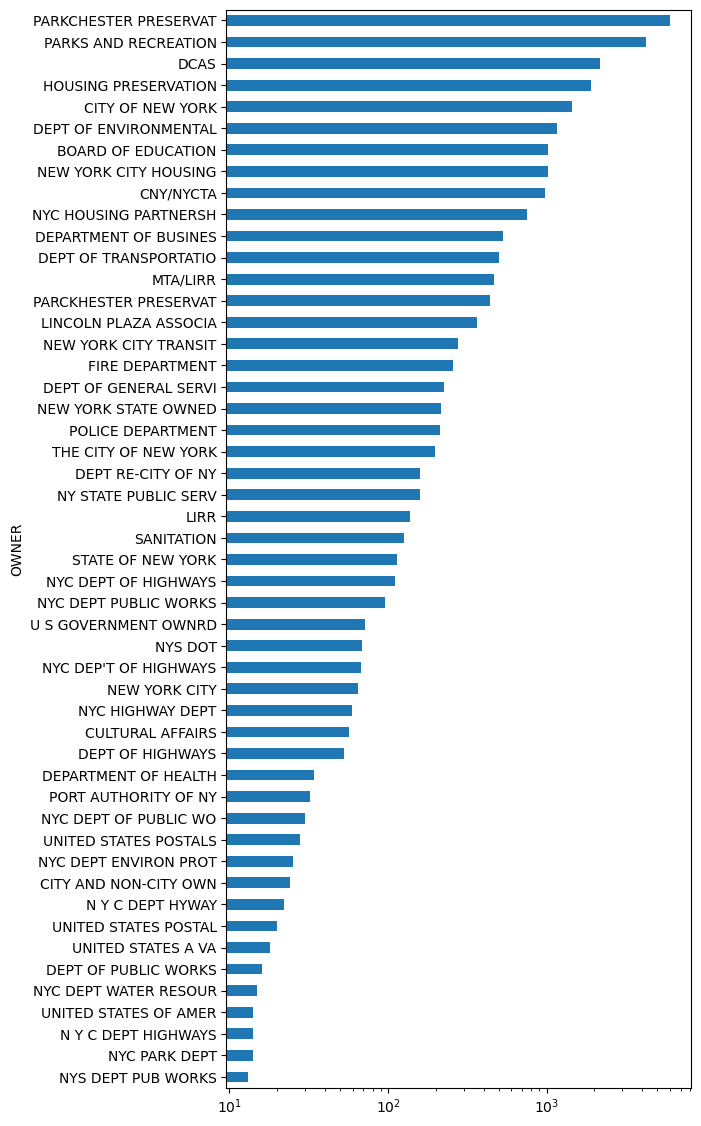

In [16]:
# any on this list that we shouldn't remove? If so, go back and remove them from the remove list.
# plt.rcParams.update({'figure.figsize':(6,14)})
plt.figure(figsize=(6,14))
plt.xscale('log')
removed['OWNER'].value_counts().head(50).sort_values().plot(kind='barh')

In [17]:
data.shape

(1044492, 32)

In [18]:
# this is how many records we removed
numrecords_orig - len(data)

26502

In [19]:
data.head(10)

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,636093.0,2049290.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,919276.0,2961617.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
2,11,1000041003,1,4,1003,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,967500.0,5483912.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
3,12,1000041004,1,4,1004,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,163174.0,525692.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
4,13,1000041005,1,4,1005,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,373783.0,1204211.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
5,14,1000041006,1,4,1006,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,353383.0,1138493.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
6,15,1000041007,1,4,1007,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,1246572.0,4016063.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
7,16,1000041008,1,4,1008,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,1213369.0,3909089.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
8,17,1000041009,1,4,1009,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,1213369.0,3909089.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
9,18,1000041010,1,4,1010,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,1213369.0,3909089.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR


## Fill in missing ZIP

In [20]:
# How many zips are missing? Replace NAN with 0 and count them.
missing_zips = np.where(pd.isnull(data['ZIP']))[0]
num_missing_zips_orig = len(missing_zips)
num_missing_zips_orig

20431

In [21]:
sum(data['BORO'].isna())

0

In [22]:
sum(data['STADDR'].isna())

364

In [23]:
# concatenate the 'staddr' and 'boro' columns into a new 'staddr_boro' column 
data['staddr_boro'] = data[data['STADDR'].notnull()]['STADDR'] + '_' + data[data['BORO'].notnull()]['BORO'].astype(str)
data['staddr_boro']

0              1 WATER STREET_1
1              1 WATER STREET_1
2              1 WATER STREET_1
3              1 WATER STREET_1
4              1 WATER STREET_1
                   ...         
1044487    142 BENTLEY STREET_5
1044488    146 BENTLEY STREET_5
1044489    150 BENTLEY STREET_5
1044490    156 BENTLEY STREET_5
1044491    162 BENTLEY STREET_5
Name: staddr_boro, Length: 1044492, dtype: object

In [24]:
staddr_boro_zip = {}
for index, staddrboro in data['staddr_boro'].items():
    if staddrboro not in staddr_boro_zip :
        staddr_boro_zip [staddrboro] = data.loc[index, 'ZIP']
        
        
# fill in by mapping with street addrees boroughs
data['ZIP'] = data['ZIP'].fillna(data['staddr_boro'].map(staddr_boro_zip))

In [25]:
# how many missing zips did we fill in with this last step?
num_filled_in = num_missing_zips_orig - len(np.where(pd.isnull(data['ZIP']))[0])
num_filled_in

2832

In [26]:
# How many are still left to fill in?
missing_zips = np.where(pd.isnull(data['ZIP']))[0]
len(missing_zips)

17599

In [27]:
%%time
# Assume data is sorted by zip. Fill in a missing zip if the previous and next record have the same zip
zip_forward_filled = data['ZIP'].fillna(method='ffill')
zip_backward_filled = data['ZIP'].fillna(method='bfill')
data['ZIP'] = data['ZIP'].mask((zip_forward_filled == zip_backward_filled) & data['ZIP'].isna(),zip_forward_filled)

CPU times: user 8.31 ms, sys: 4.3 ms, total: 12.6 ms
Wall time: 9.98 ms


<timed exec>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
<timed exec>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


In [28]:
# how many missing zips did we fill in with this last step?
num_filled_in = len(missing_zips) - len(np.where(pd.isnull(data['ZIP']))[0])
num_filled_in

16126

In [29]:
# How many are still left to fill in?
missing_zips = np.where(pd.isnull(data['ZIP']))[0]
len(missing_zips)

1473

In [30]:
%time
data['ZIP'].fillna(method='ffill', inplace=True)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 2.86 µs


/var/folders/lj/vjjcnvz53rq6gytkbpl_lsvr0000gn/T/ipykernel_61355/2418375584.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['ZIP'].fillna(method='ffill', inplace=True)


In [31]:
# For the remaining missing zips, just fill in with the previous record's zip.
missing_zips = np.where(pd.isnull(data['ZIP']))[0]
len(missing_zips)

0

In [32]:
data = data.drop('staddr_boro', axis=1)

### FULLVAL, AVLAND, AVTOT

#### FULLVAL

In [33]:
len(data[data['FULLVAL']==0])

10025

In [34]:
data['FULLVAL'].isnull().sum()

0

In [35]:
data['FULLVAL'].replace(0, np.nan, inplace=True)
data['FULLVAL'].isnull().sum()

10025

In [36]:
data["FULLVAL"] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['FULLVAL'].transform(lambda x: x.fillna(x.mean()))
data['FULLVAL'].isnull().sum()

7307

In [37]:
data["FULLVAL"] = data.\
                        groupby(['TAXCLASS','BORO'])['FULLVAL'].transform(lambda x: x.fillna(x.mean()))
data['FULLVAL'].isnull().sum()

386

In [38]:
data["FULLVAL"] = data.\
                        groupby(['TAXCLASS'])['FULLVAL'].transform(lambda x: x.fillna(x.mean()))
data['FULLVAL'].isnull().sum()

0

#### AVLAND

In [39]:
len(data[data['AVLAND']==0])

10027

In [40]:
data['AVLAND'].isnull().sum()

0

In [41]:
data['AVLAND'].replace(0, np.nan, inplace=True)
data['AVLAND'].isnull().sum()

10027

In [42]:
data["AVLAND"] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['AVLAND'].transform(lambda x: x.fillna(x.mean()))
data['AVLAND'].isnull().sum()

7307

In [43]:
data["AVLAND"] = data.\
                        groupby(['TAXCLASS','BORO'])['AVLAND'].transform(lambda x: x.fillna(x.mean()))
data['AVLAND'].isnull().sum()

386

In [44]:
data["AVLAND"] = data.\
                        groupby(['TAXCLASS'])['AVLAND'].transform(lambda x: x.fillna(x.mean()))
data['AVLAND'].isnull().sum()

0

#### AVTOT

In [45]:
len(data[data['AVTOT']==0])

10025

In [46]:
data['AVTOT'].isnull().sum()

0

In [47]:
data['AVTOT'].replace(0, np.nan, inplace=True)
data['AVTOT'].isnull().sum()

10025

In [48]:
data["AVTOT"] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['AVTOT'].transform(lambda x: x.fillna(x.mean()))
data['AVTOT'].isnull().sum()

7307

In [49]:
data["AVTOT"] = data.\
                        groupby(['TAXCLASS','BORO'])['AVTOT'].transform(lambda x: x.fillna(x.mean()))
data['AVTOT'].isnull().sum()

386

In [50]:
data["AVTOT"] = data.\
                        groupby(['TAXCLASS'])['AVTOT'].transform(lambda x: x.fillna(x.mean()))
data['AVTOT'].isnull().sum()

0

In [51]:
data.head().transpose()

,0,1,2,3,4
RECORD,9,10,11,12,13
BBLE,1000041001,1000041002,1000041003,1000041004,1000041005
BORO,1,1,1,1,1
BLOCK,4,4,4,4,4
LOT,1001,1002,1003,1004,1005
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,R5,R5,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,0,0,0,0,0


## Fill in the missing STORIES

In [52]:
data['STORIES'].isnull().sum()

42029

In [53]:
modes = data.groupby(['BORO', 'BLDGCL'])['STORIES'] \
         .transform(lambda x: x.mode(dropna=False).iloc[0])
data['STORIES'] = data['STORIES'].fillna(modes)

In [54]:
data['STORIES'].isnull().sum()

37921

In [55]:
data["STORIES"] = data.\
                        groupby(['TAXCLASS'])['STORIES'].transform(lambda x: x.fillna(x.mean()))

In [56]:
data['STORIES'].isnull().sum()

0

In [57]:
data.head().transpose()

,0,1,2,3,4
RECORD,9,10,11,12,13
BBLE,1000041001,1000041002,1000041003,1000041004,1000041005
BORO,1,1,1,1,1
BLOCK,4,4,4,4,4
LOT,1001,1002,1003,1004,1005
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,R5,R5,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,0,0,0,0,0


## Fill in LTFRONT, LTDEPTH, BLDDEPTH, BLDFRONT with averages by TAXCLASS

In [58]:
# Because these 4 fields do not have NAs, we just need to replace 0s. 
# We think zero and 1 are invalid values for these fields, so replace them with NA.
# Probably OK for BLD dimensions to be zero. Property could have no building.
# Calculate groupwise average. Replace 0 and 1's by NAs so they are not counted in calculating mean.
# Not sure which values to treat as missing. Here are some choices.
data.loc[data['LTFRONT']==0,'LTFRONT']=np.nan
data.loc[data['LTDEPTH']==0,'LTDEPTH']=np.nan
# data.loc[data['BLDFRONT']==0,'BLDFRONT']=np.nan
# data.loc[data['BLDDEPTH']==0,'BLDDEPTH']=np.nan
data.loc[data['LTFRONT']==1,'LTFRONT']=np.nan
data.loc[data['LTDEPTH']==1,'LTDEPTH']=np.nan
data.loc[data['BLDFRONT']==1,'BLDFRONT']=np.nan
data.loc[data['BLDDEPTH']==1,'BLDDEPTH']=np.nan

In [59]:
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,0.0,0.0,636093.0,2049290.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,0.0,0.0,919276.0,2961617.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
2,11,1000041003,1,4,1003,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,0.0,0.0,967500.0,5483912.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
3,12,1000041004,1,4,1004,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,0.0,0.0,163174.0,525692.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
4,13,1000041005,1,4,1005,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,0.0,0.0,373783.0,1204211.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR


#### LTFRONT

In [60]:
data['LTFRONT'].isnull().sum()

161133

In [61]:
data["LTFRONT"] = data.\
                        groupby(['TAXCLASS','BORO'])['LTFRONT'].transform(lambda x: x.fillna(x.mean()))
data['LTFRONT'].isnull().sum()

2

In [62]:
data["LTFRONT"] = data.\
                        groupby(['TAXCLASS'])['LTFRONT'].transform(lambda x: x.fillna(x.mean()))
data['LTFRONT'].isnull().sum()

0

#### LTDEPTH

In [63]:
data['LTDEPTH'].isnull().sum()

161715

In [64]:
data["LTDEPTH"] = data.\
                        groupby(['TAXCLASS','BORO'])['LTDEPTH'].transform(lambda x: x.fillna(x.mean()))
data['LTDEPTH'].isnull().sum()

2

In [65]:
data["LTDEPTH"] = data.\
                        groupby(['TAXCLASS'])['LTDEPTH'].transform(lambda x: x.fillna(x.mean()))
data['LTDEPTH'].isnull().sum()

0

#### BLDFRONT

In [66]:
data['BLDFRONT'].isnull().sum()

75

In [67]:
data['BLDFRONT'] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['BLDFRONT'].transform(lambda x: x.fillna(x.mean()))
data['BLDFRONT'].isnull().sum()

0

In [68]:
data['BLDFRONT'] = data.\
                        groupby(['TAXCLASS','BORO'])['BLDFRONT'].transform(lambda x: x.fillna(x.mean()))
data['BLDFRONT'].isnull().sum()

0

In [69]:
data['BLDFRONT'] = data.\
                        groupby(['TAXCLASS'])['BLDFRONT'].transform(lambda x: x.fillna(x.mean()))
data['BLDFRONT'].isnull().sum()

0

#### BLDEPTH

In [70]:
data['BLDDEPTH'].isnull().sum()

58

In [71]:
data['BLDDEPTH'] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['BLDDEPTH'].transform(lambda x: x.fillna(x.mean()))
data['BLDDEPTH'].isnull().sum()

0

In [72]:
data['BLDDEPTH'] = data.\
                        groupby(['TAXCLASS','BORO'])['BLDDEPTH'].transform(lambda x: x.fillna(x.mean()))
data['BLDDEPTH'].isnull().sum()

0

In [73]:
data['BLDDEPTH'] = data.\
                        groupby(['TAXCLASS'])['BLDDEPTH'].transform(lambda x: x.fillna(x.mean()))
data['BLDDEPTH'].isnull().sum()

0

In [74]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT     float64
LTDEPTH     float64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT    float64
BLDDEPTH    float64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [75]:
# convert ZIP to a string rather than a float
# We call the first three digits of the zip zip3
data['ZIP'] = data['ZIP'].astype(str)
data['zip3'] = data['ZIP'].str[:3]

In [76]:
data.count()

RECORD      1044492
BBLE        1044492
BORO        1044492
BLOCK       1044492
LOT         1044492
EASEMENT       1976
OWNER       1012748
BLDGCL      1044492
TAXCLASS    1044492
LTFRONT     1044492
LTDEPTH     1044492
EXT          353646
STORIES     1044492
FULLVAL     1044492
AVLAND      1044492
AVTOT       1044492
EXLAND      1044492
EXTOT       1044492
EXCD1        623528
STADDR      1044128
ZIP         1044492
EXMPTCL        9295
BLDFRONT    1044492
BLDDEPTH    1044492
AVLAND2      266065
AVTOT2       266071
EXLAND2       80844
EXTOT2       117833
EXCD2         92904
PERIOD      1044492
YEAR        1044492
VALTYPE     1044492
zip3        1044492
dtype: int64

In [77]:
cols = data.columns
print(cols)

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3'],
      dtype='object')


### Now build variables that try to find properties that are unusual in ways we're interested in

In [78]:
# epsilon is an arbitrary small number to make sure we don't divide by zero
epsilon = .0001
data['ltsize'] = data['LTFRONT'] * data['LTDEPTH'] + epsilon
data['bldsize'] = data['BLDFRONT'] * data['BLDDEPTH'] + epsilon
data['bldvol'] = data['bldsize'] * data['STORIES'] + epsilon

In [79]:
data['r1'] = data['FULLVAL'] / data['ltsize']
data['r2'] = data['FULLVAL'] / data['bldsize']
data['r3'] = data['FULLVAL'] / data['bldvol']
data['r4'] = data['AVLAND'] / data['ltsize']
data['r5'] = data['AVLAND'] / data['bldsize']
data['r6'] = data['AVLAND'] / data['bldvol']
data['r7'] = data['AVTOT'] / data['ltsize']
data['r8'] = data['AVTOT'] / data['bldsize']
data['r9'] = data['AVTOT'] / data['bldvol']

In [80]:
data.describe()

,RECORD,BORO,BLOCK,LOT,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,...,bldvol,r1,r2,r3,r4,r5,r6,r7,r8,r9
count,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,...,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06
mean,5.368071e+05,3.220281e+00,4.756780e+03,3.509016e+02,5.045399e+01,1.073810e+02,4.969850e+00,8.163420e+05,6.643735e+04,1.998216e+05,...,1.882881e+04,2.107176e+02,8.691048e+08,1.025811e+08,9.964520e+00,1.229273e+08,1.614537e+07,2.534231e+01,3.768438e+08,4.167343e+07
std,3.080025e+05,1.199074e+00,3.677416e+03,8.267098e+02,5.999403e+01,5.153434e+01,8.225043e+00,6.394366e+06,2.009129e+06,5.391132e+06,...,2.320270e+06,4.571328e+02,2.914578e+10,3.376951e+09,6.514882e+01,1.792873e+10,4.400470e+09,1.593315e+02,4.746549e+10,1.150766e+10
min,9.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,...,2.000000e-04,3.614764e-04,4.167249e-03,1.344274e-04,8.333333e-06,3.217901e-04,1.038033e-05,8.333333e-06,1.875268e-03,6.049251e-05
25%,2.729098e+05,3.000000e+00,1.542000e+03,2.300000e+01,2.100000e+01,1.000000e+02,2.000000e+00,3.181550e+05,9.679000e+03,1.892600e+04,...,9.890002e+02,7.566667e+01,4.586805e+02,2.176470e+02,2.370748e+00,1.355000e+01,6.486902e+00,5.378464e+00,2.450623e+01,1.168055e+01
50%,5.387725e+05,3.000000e+00,4.078000e+03,4.900000e+01,3.000000e+01,1.000000e+02,2.000000e+00,4.540000e+05,1.387800e+04,2.579100e+04,...,1.548800e+03,1.533719e+02,6.365131e+02,3.102940e+02,4.590250e+00,1.884557e+01,9.274471e+00,8.619412e+00,3.302222e+01,1.613286e+01
75%,8.022752e+05,4.000000e+00,6.920000e+03,1.400000e+02,6.000000e+01,1.120598e+02,4.000000e+00,6.240000e+05,1.998000e+04,4.724400e+04,...,2.520000e+03,2.430000e+02,1.073529e+03,5.109755e+02,7.215789e+00,3.453179e+01,1.704545e+01,1.352433e+01,1.077928e+02,4.291773e+01
max,1.070994e+06,5.000000e+00,1.635000e+04,9.450000e+03,9.999000e+03,9.619000e+03,1.190000e+02,1.663775e+09,1.792809e+09,4.668309e+09,...,2.205711e+09,8.586666e+04,1.663775e+13,2.376821e+12,3.728371e+04,1.792809e+13,4.482022e+12,3.864000e+04,4.668309e+13,1.167077e+13


I want outliers in these 9 variables, either very high or very low. Very high is easy to find but very low might be close to
zero and probably not many standard deviations below the average. A simple way to look for outliers that are very low is to also include 1/over these variables, which will be very large outliers when the variables are very low.
First I scale them all to have reasonable average.

In [81]:
vars9 = ['r1','r2','r3','r4','r5','r6','r7','r8','r9']
for vars in vars9:
    data[vars] = data[vars]/data[vars].median()
    
data.describe()

,RECORD,BORO,BLOCK,LOT,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,...,bldvol,r1,r2,r3,r4,r5,r6,r7,r8,r9
count,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,...,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06
mean,5.368071e+05,3.220281e+00,4.756780e+03,3.509016e+02,5.045399e+01,1.073810e+02,4.969850e+00,8.163420e+05,6.643735e+04,1.998216e+05,...,1.882881e+04,1.373900e+00,1.365416e+06,3.305932e+05,2.170801e+00,6.522877e+06,1.740841e+06,2.940143e+00,1.141183e+07,2.583140e+06
std,3.080025e+05,1.199074e+00,3.677416e+03,8.267098e+02,5.999403e+01,5.153434e+01,8.225043e+00,6.394366e+06,2.009129e+06,5.391132e+06,...,2.320270e+06,2.980552e+00,4.578976e+07,1.088307e+07,1.419287e+01,9.513500e+08,4.744712e+08,1.848519e+01,1.437380e+09,7.133054e+08
min,9.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,...,2.000000e-04,2.356863e-06,6.546997e-06,4.332258e-07,1.815442e-06,1.707511e-05,1.119236e-06,9.668100e-07,5.678806e-05,3.749645e-06
25%,2.729098e+05,3.000000e+00,1.542000e+03,2.300000e+01,2.100000e+01,1.000000e+02,2.000000e+00,3.181550e+05,9.679000e+03,1.892600e+04,...,9.890002e+02,4.933542e-01,7.206144e-01,7.014218e-01,5.164747e-01,7.190018e-01,6.994363e-01,6.239943e-01,7.421134e-01,7.240224e-01
50%,5.387725e+05,3.000000e+00,4.078000e+03,4.900000e+01,3.000000e+01,1.000000e+02,2.000000e+00,4.540000e+05,1.387800e+04,2.579100e+04,...,1.548800e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
75%,8.022752e+05,4.000000e+00,6.920000e+03,1.400000e+02,6.000000e+01,1.120598e+02,4.000000e+00,6.240000e+05,1.998000e+04,4.724400e+04,...,2.520000e+03,1.584384e+00,1.686579e+00,1.646746e+00,1.571982e+00,1.832356e+00,1.837889e+00,1.569055e+00,3.264251e+00,2.660268e+00
max,1.070994e+06,5.000000e+00,1.635000e+04,9.450000e+03,9.999000e+03,9.619000e+03,1.190000e+02,1.663775e+09,1.792809e+09,4.668309e+09,...,2.205711e+09,5.598592e+02,2.613890e+10,7.659900e+09,8.122370e+03,9.513159e+11,4.832645e+11,4.482904e+03,1.413687e+12,7.234161e+11


In [82]:
# add in the inverse of all the 9 primary variables.
for vars in vars9:
    data[vars+'inv'] = 1/(data[vars] + epsilon)

In [83]:
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,r9,r1inv,r2inv,r3inv,r4inv,r5inv,r6inv,r7inv,r8inv,r9inv
0,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,70.813856,...,2.157505e+07,0.319454,1.613565e-08,4.011648e-07,0.059294,2.962707e-09,7.435988e-08,0.039897,1.860257e-09,4.634984e-08
1,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,70.813856,...,3.118004e+07,0.221048,1.116507e-08,2.775862e-07,0.041028,2.050045e-09,5.145332e-08,0.027607,1.287206e-09,3.207180e-08
2,11,1000041003,1,4,1003,NaN,"TRZ HOLDINGS, LLC",R5,4,70.813856,...,5.797447e+07,0.118886,6.004840e-09,1.492924e-07,0.038983,1.947862e-09,4.888868e-08,0.014848,6.922897e-10,1.724897e-08
3,12,1000041004,1,4,1004,NaN,"TRZ HOLDINGS, LLC",R5,4,70.813856,...,5.534532e+06,1.245200,6.290102e-08,1.563846e-06,0.231138,1.154937e-08,2.898734e-07,0.155527,7.251765e-09,1.806837e-07
4,13,1000041005,1,4,1005,NaN,"TRZ HOLDINGS, LLC",R5,4,70.813856,...,1.267796e+07,0.543627,2.745927e-08,6.826928e-07,0.100904,5.041848e-09,1.265435e-07,0.067895,3.165740e-09,7.887705e-08


Now I want the large outliers where the variables are either very low or very high, so I'll keep only one of the two, r or rinv, depending on which is largest. This allows me to find both the very low and high outliers.

In [84]:
for vars in vars9:
    data[vars] = data[[vars,vars+'inv']].max(axis=1)

Now I can remove the inverse columns since I have the 9 variables that I need

In [85]:
for vars in vars9:
    data.drop(columns=(vars+'inv'),inplace=True)

data.describe()

,RECORD,BORO,BLOCK,LOT,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,...,bldvol,r1,r2,r3,r4,r5,r6,r7,r8,r9
count,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,...,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06
mean,5.368071e+05,3.220281e+00,4.756780e+03,3.509016e+02,5.045399e+01,1.073810e+02,4.969850e+00,8.163420e+05,6.643735e+04,1.998216e+05,...,1.882881e+04,1.294407e+01,1.365419e+06,3.306131e+05,8.518748e+00,6.522880e+06,1.740853e+06,5.746087e+00,1.141183e+07,2.583144e+06
std,3.080025e+05,1.199074e+00,3.677416e+03,8.267098e+02,5.999403e+01,5.153434e+01,8.225043e+00,6.394366e+06,2.009129e+06,5.391132e+06,...,2.320270e+06,1.088700e+02,4.578976e+07,1.088307e+07,7.580206e+01,9.513500e+08,4.744712e+08,5.249257e+01,1.437380e+09,7.133054e+08
min,9.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,...,2.000000e-04,9.999570e-01,9.999527e-01,9.999526e-01,9.999539e-01,9.999542e-01,9.999570e-01,9.999514e-01,9.999505e-01,9.999505e-01
25%,2.729098e+05,3.000000e+00,1.542000e+03,2.300000e+01,2.100000e+01,1.000000e+02,2.000000e+00,3.181550e+05,9.679000e+03,1.892600e+04,...,9.890002e+02,1.269474e+00,1.175687e+00,1.193296e+00,1.262922e+00,1.164241e+00,1.190033e+00,1.233189e+00,1.167393e+00,1.193659e+00
50%,5.387725e+05,3.000000e+00,4.078000e+03,4.900000e+01,3.000000e+01,1.000000e+02,2.000000e+00,4.540000e+05,1.387800e+04,2.579100e+04,...,1.548800e+03,1.701746e+00,1.463995e+00,1.492702e+00,1.682360e+00,1.461362e+00,1.524923e+00,1.585997e+00,1.468319e+00,1.502809e+00
75%,8.022752e+05,4.000000e+00,6.920000e+03,1.400000e+02,6.000000e+01,1.120598e+02,4.000000e+00,6.240000e+05,1.998000e+04,4.724400e+04,...,2.520000e+03,3.207889e+00,5.341069e+00,5.831286e+00,3.260424e+00,7.953975e+00,9.407930e+00,2.710417e+00,4.898251e+00,4.631073e+00
max,1.070994e+06,5.000000e+00,1.635000e+04,9.450000e+03,9.999000e+03,9.619000e+03,1.190000e+02,1.663775e+09,1.792809e+09,4.668309e+09,...,2.205711e+09,9.769741e+03,2.613890e+10,7.659900e+09,9.821693e+03,9.513159e+11,4.832645e+11,9.904245e+03,1.413687e+12,7.234161e+11


Now I add more variables where I standardize each of these 9 basic variables by a few logical groupings.
For example, is a property's value of r1 typical for that zip code? for that taxclass?

In [86]:
# Standardized variables by appropriate logical group
zip5_mean = data.groupby('ZIP')[vars9].mean()
taxclass_mean = data.groupby('TAXCLASS')[vars9].mean()
data = data.join(zip5_mean, on='ZIP', rsuffix='_zip5')
data = data.join(taxclass_mean, on='TAXCLASS', rsuffix='_taxclass')
rsuffix = ['_zip5', '_taxclass']
for var in vars9:
    for r in rsuffix:
        data[str(var)+r] = data[var] / data[str(var)+r]

In [87]:
# include two more possibly interesting variables
data['value_ratio'] = data['FULLVAL']/(data['AVLAND']+data['AVTOT'])
data['value_ratio'] = data['value_ratio']/data['value_ratio'].mean()
# again, use 1/variable if that's larger, in order to find the low outliers
data['value_ratio'] = np.where(data['value_ratio'] < 1, 1/(data['value_ratio']+epsilon), data['value_ratio'])
data['size_ratio'] = data['bldsize'] / (data['ltsize']+1)

In [88]:
data.head().transpose()

,0,1,2,3,4
RECORD,9,10,11,12,13
BBLE,1000041001,1000041002,1000041003,1000041004,1000041005
BORO,1,1,1,1,1
BLOCK,4,4,4,4,4
LOT,1001,1002,1003,1004,1005
...,...,...,...,...,...
r7_taxclass,1.288211,1.86171,3.461563,0.330458,0.756981
r8_taxclass,7.20413,10.411337,19.358271,1.848037,4.233301
r9_taxclass,1.127871,1.629988,3.03071,0.289327,0.662761
value_ratio,8.056712,8.056715,7.13503,8.056724,8.05672


In [89]:
data.columns

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3', 'ltsize', 'bldsize',
       'bldvol', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9',
       'r1_zip5', 'r2_zip5', 'r3_zip5', 'r4_zip5', 'r5_zip5', 'r6_zip5',
       'r7_zip5', 'r8_zip5', 'r9_zip5', 'r1_taxclass', 'r2_taxclass',
       'r3_taxclass', 'r4_taxclass', 'r5_taxclass', 'r6_taxclass',
       'r7_taxclass', 'r8_taxclass', 'r9_taxclass', 'value_ratio',
       'size_ratio'],
      dtype='object')

In [90]:
save_record = data['RECORD']
save_record.head()

0     9
1    10
2    11
3    12
4    13
Name: RECORD, dtype: int64

In [91]:
dropcols = ['RECORD','BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT',
       'OWNER', 'BLDGCL', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES',
       'FULLVAL', 'AVLAND', 'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR',
       'ZIP', 'EXMPTCL', 'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2',
       'EXLAND2', 'EXTOT2', 'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3','ltsize','bldsize','bldvol']
data = data.drop(columns = dropcols)
data.shape

(1044492, 29)

In [92]:
# this dataframe is now just the variables for our unsupervised fraud models
data.head().transpose()

,0,1,2,3,4
r1,3.130243e+00,4.523796e+00,8.411301e+00,1.245200e+00,1.839398e+00
r2,6.197457e+07,8.956501e+07,1.665323e+08,1.589799e+07,3.641757e+07
r3,2.492741e+06,3.602484e+06,6.698264e+06,6.394491e+05,1.464788e+06
r4,1.686504e+01,2.437321e+01,2.565179e+01,4.326310e+00,9.910288e+00
r5,3.375292e+08,4.877942e+08,5.133833e+08,8.658481e+07,1.983400e+08
r6,1.344811e+07,1.943509e+07,2.045463e+07,3.449782e+06,7.902422e+06
r7,2.506448e+01,3.622294e+01,6.735096e+01,6.429659e+00,1.472843e+01
r8,5.375602e+08,7.768767e+08,1.444482e+09,1.378975e+08,3.158819e+08
r9,2.157505e+07,3.118004e+07,5.797447e+07,5.534532e+06,1.267796e+07
r1_zip5,3.448109e-01,4.983172e-01,9.265440e-01,1.371645e-01,2.026182e-01


In [93]:
# Calculate and write the basic statistics of all the variables to check if everything looks OK
stats = data.describe().transpose()
# stats.to_excel('stats_on_vars.xlsx')
stats

,count,mean,std,min,25%,50%,75%,max
r1,1044492.0,1.294407e+01,1.088700e+02,9.999570e-01,1.269474e+00,1.701746,3.207889,9.769741e+03
r2,1044492.0,1.365419e+06,4.578976e+07,9.999527e-01,1.175687e+00,1.463995,5.341069,2.613890e+10
r3,1044492.0,3.306131e+05,1.088307e+07,9.999526e-01,1.193296e+00,1.492702,5.831286,7.659900e+09
r4,1044492.0,8.518748e+00,7.580206e+01,9.999539e-01,1.262922e+00,1.682360,3.260424,9.821693e+03
r5,1044492.0,6.522880e+06,9.513500e+08,9.999542e-01,1.164241e+00,1.461362,7.953975,9.513159e+11
r6,1044492.0,1.740853e+06,4.744712e+08,9.999570e-01,1.190033e+00,1.524923,9.407930,4.832645e+11
r7,1044492.0,5.746087e+00,5.249257e+01,9.999514e-01,1.233189e+00,1.585997,2.710417,9.904245e+03
r8,1044492.0,1.141183e+07,1.437380e+09,9.999505e-01,1.167393e+00,1.468319,4.898251,1.413687e+12
r9,1044492.0,2.583144e+06,7.133054e+08,9.999505e-01,1.193659e+00,1.502809,4.631073,7.234161e+11
r1_zip5,1044492.0,1.000000e+00,8.217454e+00,5.039810e-03,1.620008e-01,0.321577,0.664211,2.284920e+03


In [94]:
# data.to_csv('NY vars.csv', index=False)

In [95]:
data.isna().sum().sum()

0

In [96]:
# zscale all the variables
data_zs = (data - data.mean()) / data.std()
data_zs_save = data_zs.copy()
data_zs.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
r1,1044492.0,3.823151e-17,1.0,-0.109710,-0.107234,-0.103264,-0.089429,89.618766
r2,1044492.0,3.983696e-17,1.0,-0.029819,-0.029819,-0.029819,-0.029819,570.816079
r3,1044492.0,1.655111e-17,1.0,-0.030379,-0.030379,-0.030379,-0.030378,703.806269
r4,1044492.0,6.536091e-17,1.0,-0.099190,-0.095721,-0.090187,-0.069369,129.457889
r5,1044492.0,-8.520456e-19,1.0,-0.006856,-0.006856,-0.006856,-0.006856,999.957285
r6,1044492.0,-1.090992e-18,1.0,-0.003669,-0.003669,-0.003669,-0.003669,1018.529092
r7,1044492.0,7.278952e-17,1.0,-0.090415,-0.085972,-0.079251,-0.057830,188.569522
r8,1044492.0,-6.017040e-18,1.0,-0.007939,-0.007939,-0.007939,-0.007939,983.508585
r9,1044492.0,1.787425e-18,1.0,-0.003621,-0.003621,-0.003621,-0.003621,1014.170858
r1_zip5,1044492.0,-2.680287e-17,1.0,-0.121079,-0.101978,-0.082559,-0.040863,277.935175


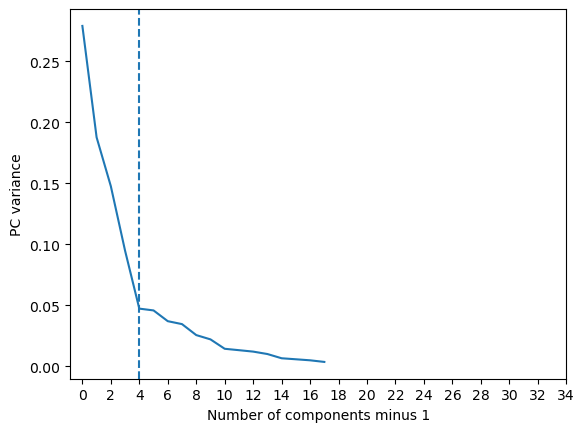

In [97]:
# do a complete PCA and look at the scree and cumulative variance plots
pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data_zs)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=4, linestyle='--')

(0.0, 1.0)

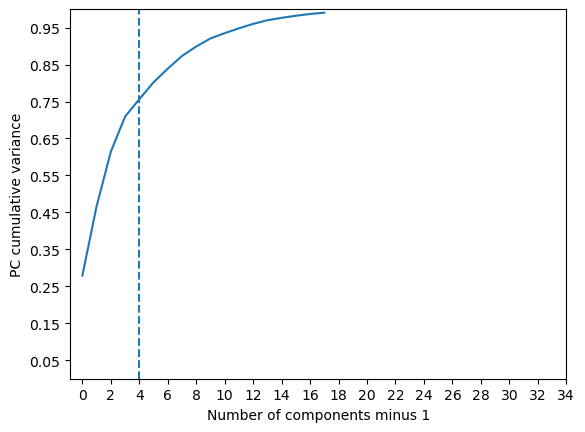

In [98]:
plt.xlabel('Number of components minus 1')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('PC cumulative variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=4, linestyle='--')
plt.ylim(0,1)

In [99]:
%%time
# now redo the PCA but just keep the top few PCs
data_zs = data_zs_save.copy()
pca = PCA(n_components = 5, svd_solver = 'full')
princ_comps = pca.fit_transform(data_zs)
pca.n_components_

CPU times: user 3.24 s, sys: 289 ms, total: 3.52 s
Wall time: 574 ms


5

In [100]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.27908514 0.4667656  0.61435657 0.7090587  0.7562435 ]


In [101]:
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape

(1044492, 5)

In [102]:
data_pca.head(5)

,PC1,PC2,PC3,PC4,PC5
0,0.625151,0.037534,0.077495,0.126964,0.863770
1,0.962183,0.258705,0.119726,0.163168,1.152296
2,1.667141,0.690240,0.258814,0.152342,2.000525
3,0.062475,-0.328045,0.006789,0.066493,0.381345
4,0.312960,-0.167336,0.038376,0.093430,0.596509


In [103]:
data_pca.describe()

,PC1,PC2,PC3,PC4,PC5
count,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06
mean,3.056616e-16,-6.851739e-17,1.320416e-16,7.799363e-17,8.244944e-18
std,2.844902e+00,2.332967e+00,2.068849e+00,1.657215e+00,1.169769e+00
min,-5.015535e-01,-1.225369e+02,-6.098382e+02,-5.798701e+02,-2.231438e+02
25%,-1.243610e-01,-2.692587e-01,-4.136593e-02,4.618834e-02,-8.575840e-02
50%,-1.199425e-01,-2.119116e-01,-3.765687e-02,5.218774e-02,-4.856385e-02
75%,-9.894908e-02,-1.209430e-01,-3.125217e-02,5.267692e-02,1.064451e-01
max,2.078522e+03,4.562133e+02,9.392000e+02,1.101210e+03,4.471563e+02


# zscale the pcs.
I do this (make all the retained PCs equally important) if I only keep a small number of PCs.
Alternatively you can keep maybe up to 6 to 8 or so, and don't do this second z scale.
I prefer to keep a somewhat small number of PCs and then make them all equally important via zscaling.
This second zscale step makes the later Minkowski distance to be similar to a Mahalanobis distance.
Many people don't do this second zscaling but I think it's better.

My point of view: Keep the top few PC's thinking that each of these is measureing a mostly independent phenonenom (since they're orthogonal). Then make them all equally important via zscale.

My choice: keep only a few top PCs and zscale them.
Alternative: keep some more of the PCs and don't zscale the PCs. Then these later PCs don't add much.

In [104]:
data_pca_zs = (data_pca - data_pca.mean()) / data_pca.std()
data_pca_zs.describe()

,PC1,PC2,PC3,PC4,PC5
count,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06
mean,-9.115697e-19,2.149672e-18,2.721104e-19,1.091843e-18,3.646279e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.762990e-01,-5.252409e+01,-2.947717e+02,-3.499064e+02,-1.907589e+02
25%,-4.371363e-02,-1.154147e-01,-1.999466e-02,2.787106e-02,-7.331226e-02
50%,-4.216051e-02,-9.083353e-02,-1.820184e-02,3.149123e-02,-4.151577e-02
75%,-3.478119e-02,-5.184085e-02,-1.510606e-02,3.178641e-02,9.099668e-02
max,7.306128e+02,1.955507e+02,4.539721e+02,6.644945e+02,3.822603e+02


In [105]:
data_pca_zs.shape

(1044492, 5)

In [106]:
data_pca_zs.head(5)

,PC1,PC2,PC3,PC4,PC5
0,0.219744,0.016089,0.037458,0.076613,0.738411
1,0.338213,0.110891,0.057871,0.098459,0.985063
2,0.586010,0.295864,0.125100,0.091926,1.710188
3,0.021960,-0.140613,0.003281,0.040123,0.326000
4,0.110007,-0.071727,0.018550,0.056378,0.509937


## Now calculate two unsupervised fraud scores

In [107]:
# Set the powers for the two Minkowski distances. The final results are relatively insensitive to these choices. 
# Reasonable choices are anywhere from 1 to about 4.
# The higher the power the more the distance measure focuses on the large dimensional displacements.
p1 = 2
p2 = 2
ntop = 10000

### Calculate score 1

In [108]:
oop1 = 1/p1
score1 = (((data_pca_zs).abs()**p1).sum(axis=1))**oop1
score1.head(10)

0    0.775287
1    1.053602
2    1.838420
3    0.357982
4    0.529910
5    0.511855
6    1.381865
7    1.348378
8    1.348378
9    1.348378
dtype: float64

In [109]:
data_pca_zs.head(10)

,PC1,PC2,PC3,PC4,PC5
0,0.219744,0.016089,0.037458,0.076613,0.738411
1,0.338213,0.110891,0.057871,0.098459,0.985063
2,0.586010,0.295864,0.125100,0.091926,1.710188
3,0.021960,-0.140613,0.003281,0.040123,0.326000
4,0.110007,-0.071727,0.018550,0.056378,0.509937
5,0.101474,-0.078555,0.017079,0.054804,0.492171
6,0.475136,0.220461,0.081463,0.123708,1.270139
7,0.461246,0.209346,0.079070,0.121146,1.241218
8,0.461246,0.209346,0.079070,0.121146,1.241218
9,0.461246,0.209346,0.079070,0.121146,1.241218


In [110]:
score1.max()

1006.4007283461835

### Autoencoder for score 2

In [111]:
%%time
# you don't need the autoencoder to be really good, just a little bit trained so it can find the really unusual records
# you can set max_iter to 100 and it takes about a minute, or 500 and it takes about 7 minutes. But even 50 is good enough.
NNmodel = MLPRegressor(hidden_layer_sizes=(3),activation='logistic',max_iter=100,random_state=1)
NNmodel.fit(data_pca_zs,data_pca_zs)

CPU times: user 35.3 s, sys: 43.6 ms, total: 35.3 s
Wall time: 35.4 s


/Users/pin/miniconda3/envs/py3k/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='logistic', hidden_layer_sizes=3, max_iter=100,
             random_state=1)

In [112]:
# calculate score 2 as the error of an autoencoder
# Again we'll use Minkowski distance for the error (difference betwen the input and output vectors)
pca_out = NNmodel.predict(data_pca_zs)
error = pca_out - data_pca_zs
oop2 = 1/p2
score2 = ((error.abs()**p2).sum(axis=1))**oop2

In [113]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['RECORD'] = save_record
scores.head(10)

,score1,score2,RECORD
0,0.775287,0.226800,9
1,1.053602,0.313333,10
2,1.838420,0.521354,11
3,0.357982,0.095664,12
4,0.529910,0.149259,13
5,0.511855,0.143530,14
6,1.381865,0.413418,15
7,1.348378,0.403301,16
8,1.348378,0.403301,17
9,1.348378,0.403301,18


In [114]:
# do a rank-order scaling. Replace the score with the sorted rank order
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores.head(20)

,score1,score2,RECORD,score1 rank,score2 rank
0,0.775287,0.226800,9,1004949.0,999931.0
1,1.053602,0.313333,10,1015068.0,1012941.0
2,1.838420,0.521354,11,1028447.0,1028273.0
3,0.357982,0.095664,12,956629.0,923125.0
4,0.529910,0.149259,13,987777.0,977115.0
5,0.511855,0.143530,14,985854.0,974487.0
6,1.381865,0.413418,15,1022390.0,1022270.0
7,1.348378,0.403301,16,1021860.0,1021564.0
8,1.348378,0.403301,17,1021858.0,1021562.0
9,1.348378,0.403301,18,1021856.0,1021561.0


In [115]:
# calculate the final score as the average of the two scores
# you could do other possible combinations of these if you want
# You could do different weightings, or a max or min
weight = .5
scores['final'] = (weight*scores['score1 rank'] + (1-weight)*scores['score2 rank'])
scores_sorted = scores.sort_values(by='final', ascending=False)
scores_sorted.head(20)

,score1,score2,RECORD,score1 rank,score2 rank,final
897397,1006.400728,1005.288761,917942,1044492.0,1044492.0,1044492.0
544655,639.468504,587.387598,561383,1044491.0,1044491.0,1044491.0
1028917,485.727334,446.325893,1053832,1044490.0,1044490.0,1044490.0
148176,417.114776,381.496289,151044,1044489.0,1044489.0,1044489.0
383033,384.202091,348.415672,398266,1044488.0,1044488.0,1044488.0
676142,321.959426,289.530523,694272,1044487.0,1044487.0,1044487.0
383044,293.476973,259.276466,398284,1044486.0,1044486.0,1044486.0
29547,275.488029,242.650688,30042,1044484.0,1044485.0,1044484.5
230836,282.996129,241.479071,241946,1044485.0,1044484.0,1044484.5
1029144,255.549985,217.356242,1054166,1044481.0,1044483.0,1044482.0


In [116]:
scores_sorted.tail(10)

,score1,score2,RECORD,score1 rank,score2 rank,final
561760,0.015387,0.006203,578627,50.0,8.0,29.0
561777,0.015264,0.006158,578644,49.0,6.0,27.5
561799,0.015149,0.006178,578666,48.0,7.0,27.5
560940,0.011941,0.006786,577791,26.0,28.0,27.0
561756,0.015028,0.006139,578623,47.0,5.0,26.0
561007,0.011907,0.006775,577858,25.0,27.0,26.0
560953,0.012098,0.006656,577804,28.0,22.0,25.0
561805,0.014898,0.006128,578672,45.0,4.0,24.5
561767,0.014443,0.006100,578634,40.5,2.5,21.5
561770,0.014443,0.006100,578637,40.5,2.5,21.5


In [117]:
scores.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06
mean,2.936232e-01,1.018640e-01,5.368071e+05,5.222465e+05,5.222465e+05,5.222465e+05
std,2.216706e+00,1.723090e+00,3.080025e+05,3.015190e+05,3.015190e+05,2.983085e+05
min,8.744326e-03,5.374115e-03,9.000000e+00,1.000000e+00,1.000000e+00,2.150000e+01
25%,1.225182e-01,3.584060e-02,2.729098e+05,2.611238e+05,2.611241e+05,2.677320e+05
50%,1.416069e-01,4.230228e-02,5.387725e+05,5.222455e+05,5.222468e+05,5.215945e+05
75%,2.084633e-01,5.958568e-02,8.022752e+05,7.833692e+05,7.833235e+05,7.842996e+05
max,1.006401e+03,1.005289e+03,1.070994e+06,1.044492e+06,1.044492e+06,1.044492e+06


In [118]:
scores_sorted.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06,1.044492e+06
mean,2.936232e-01,1.018640e-01,5.368071e+05,5.222465e+05,5.222465e+05,5.222465e+05
std,2.216706e+00,1.723090e+00,3.080025e+05,3.015190e+05,3.015190e+05,2.983085e+05
min,8.744326e-03,5.374115e-03,9.000000e+00,1.000000e+00,1.000000e+00,2.150000e+01
25%,1.225182e-01,3.584060e-02,2.729098e+05,2.611238e+05,2.611241e+05,2.677320e+05
50%,1.416069e-01,4.230228e-02,5.387725e+05,5.222455e+05,5.222468e+05,5.215945e+05
75%,2.084633e-01,5.958568e-02,8.022752e+05,7.833692e+05,7.833235e+05,7.842996e+05
max,1.006401e+03,1.005289e+03,1.070994e+06,1.044492e+06,1.044492e+06,1.044492e+06


In [119]:
scores_sorted.set_index('RECORD', drop=True, inplace=True)
scores_sorted.head(10)

,score1,score2,score1 rank,score2 rank,final
RECORD,,,,,
917942,1006.400728,1005.288761,1044492.0,1044492.0,1044492.0
561383,639.468504,587.387598,1044491.0,1044491.0,1044491.0
1053832,485.727334,446.325893,1044490.0,1044490.0,1044490.0
151044,417.114776,381.496289,1044489.0,1044489.0,1044489.0
398266,384.202091,348.415672,1044488.0,1044488.0,1044488.0
694272,321.959426,289.530523,1044487.0,1044487.0,1044487.0
398284,293.476973,259.276466,1044486.0,1044486.0,1044486.0
30042,275.488029,242.650688,1044484.0,1044485.0,1044484.5
241946,282.996129,241.479071,1044485.0,1044484.0,1044484.5


### Look at the score distributions

(0.1, 2084432.0408312716)

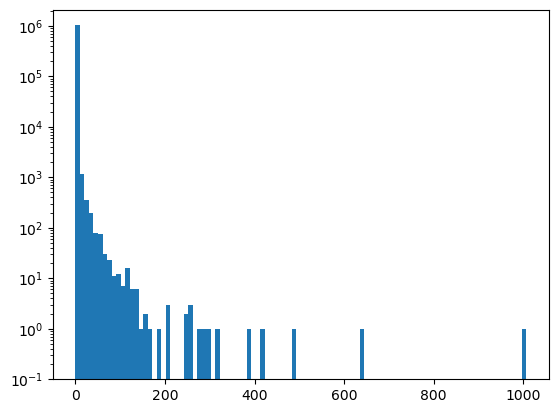

In [120]:
sc1max = int(score1.max())
plt.hist(score1, bins =100, range=(0,sc1max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

In [121]:
sc2max = int(score2.max())
sc2max

1005

1005


(0.1, 2087077.3542771842)

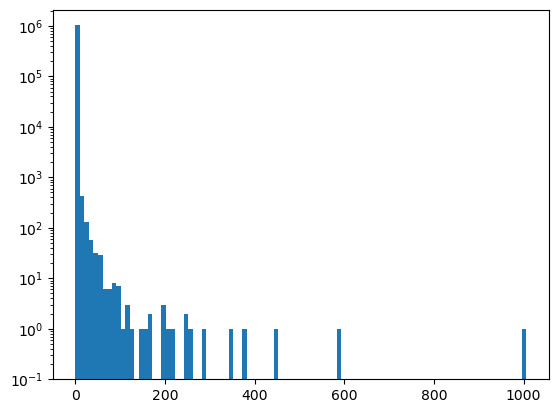

In [122]:
sc2max = int(score2.max())
print(sc2max)
plt.hist(score2, bins =100, range=(0,sc2max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

The flatter the next plot, the more similar are the two scores. 
If the two scores are very similar then the rank order hardly changes betwen the two scores and the plot is flat.

/Users/pin/miniconda3/envs/py3k/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


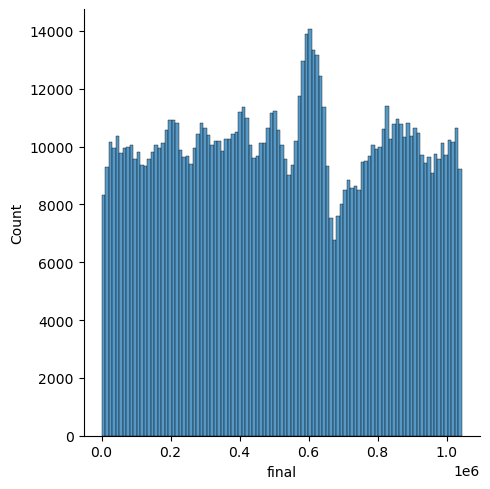

In [123]:
sns.displot(scores['final'])

In [124]:
top_records = scores_sorted.head(ntop).index
print(top_records)

Index([ 917942,  561383, 1053832,  151044,  398266,  694272,  398284,   30042,
        241946, 1054166,
       ...
         78352,   78353,   78354,   78356,   78357,   78358,   78359,   78360,
         78361,   78363],
      dtype='int64', name='RECORD', length=10000)


In [125]:
data_zs['RECORD'] = save_record
data_zs.set_index('RECORD', inplace=True, drop=True)
data_zs.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r2_taxclass,r3_taxclass,r4_taxclass,r5_taxclass,r6_taxclass,r7_taxclass,r8_taxclass,r9_taxclass,value_ratio,size_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
9,-0.090143,1.323640,0.198669,0.110106,0.347933,0.024674,0.368022,0.366047,0.026625,-0.079731,...,0.139560,0.015751,-0.105760,0.116299,-0.001598,0.061645,0.115063,0.002231,0.263334,-0.029616
10,-0.077342,1.926186,0.300639,0.209156,0.505883,0.037293,0.580594,0.532542,0.040091,-0.061051,...,0.209562,0.031334,-0.049223,0.177105,0.006233,0.184309,0.174544,0.010993,0.263334,-0.029616
11,-0.041635,3.607071,0.585097,0.226023,0.532780,0.039441,1.173592,0.997001,0.077654,-0.008939,...,0.404841,0.074804,-0.039595,0.187460,0.007566,0.526496,0.340476,0.035436,0.212785,-0.029616
12,-0.107457,0.317376,0.028378,-0.055308,0.084156,0.003602,0.013022,0.087997,0.004138,-0.105000,...,0.022655,-0.010272,-0.200177,0.014753,-0.014677,-0.143206,0.015728,-0.012401,0.263335,-0.029616
13,-0.101999,0.765502,0.104215,0.018358,0.201626,0.012986,0.171116,0.211823,0.014152,-0.097035,...,0.074717,0.001317,-0.158130,0.059975,-0.008852,-0.051979,0.059965,-0.005885,0.263334,-0.029616


In [126]:
scores.set_index('RECORD',inplace=True)
scores.drop(columns=['score1','score2'],inplace=True)
scores.head(30)

,score1 rank,score2 rank,final
RECORD,,,
9,1004949.0,999931.0,1002440.00
10,1015068.0,1012941.0,1014004.50
11,1028447.0,1028273.0,1028360.00
12,956629.0,923125.0,939877.00
13,987777.0,977115.0,982446.00
14,985854.0,974487.0,980170.50
15,1022390.0,1022270.0,1022330.00
16,1021860.0,1021564.0,1021712.00
17,1021858.0,1021562.0,1021710.00


In [127]:
scores.tail(30)

,score1 rank,score2 rank,final
RECORD,,,
1070965,576550.0,674980.0,625765.0
1070966,681323.0,705298.0,693310.5
1070967,914713.0,878871.0,896792.0
1070968,964628.0,927912.0,946270.0
1070969,918060.0,879149.0,898604.5
1070970,794971.0,805418.0,800194.5
1070971,899298.0,869720.0,884509.0
1070972,459475.0,554725.0,507100.0
1070973,812270.0,817371.0,814820.5


In [128]:
NY_data_with_scores = NY_data_orig.join(scores, on='RECORD')
NY_data_with_scores['final'].fillna(1,inplace=True)
NY_data_with_scores

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070989,1070990,5080500083,5,8050,83,NaN,"TOBIN, GALE",A1,1,60,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,717500.0,737804.0,727652.0
1070990,1070991,5080500086,5,8050,86,NaN,SHERRI MILINAZZO,A1,1,62,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,985216.0,962129.0,973672.5
1070991,1070992,5080500089,5,8050,89,NaN,JOHN GERVASI,A1,1,53,...,NaN,NaN,NaN,1017.0,FINAL,2010/11,AC-TR,963758.0,933373.0,948565.5
1070992,1070993,5080500092,5,8050,92,NaN,RITA M MOOG,A1,1,52,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,700096.0,719210.0,709653.0


### OK, now let's look at the top records, see if they make sense, and then we can adjust the algorithm/variables if we want.

In [129]:
NY_data_scored_and_sorted = NY_data_with_scores.sort_values(by=['final','RECORD'], ascending = [False,True])
NY_data_scored_zs = NY_data_with_scores.join(data_zs, on='RECORD')
NY_data_scored_zs.set_index('RECORD',inplace=True)
NY_data_scored_zs.head(20)

,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,r2_taxclass,r3_taxclass,r4_taxclass,r5_taxclass,r6_taxclass,r7_taxclass,r8_taxclass,r9_taxclass,value_ratio,size_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,1260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1000030002,1,3,2,NaN,PARKS AND RECREATION,Q1,4,496,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1000030003,1,3,3,NaN,PARKS AND RECREATION,Q1,4,180,370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1000030010,1,3,10,NaN,DEPT RE-CITY OF NY,Z9,4,362,177,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,0,0,...,0.139560,0.015751,-0.105760,0.116299,-0.001598,0.061645,0.115063,0.002231,0.263334,-0.029616


In [130]:
NY_data_scored_zs_sorted = NY_data_scored_zs.sort_values(by=['final','RECORD'], ascending = [False,True])
NY_data_top_n = NY_data_scored_zs_sorted.head(ntop)
NY_data_top_n

,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,r2_taxclass,r3_taxclass,r4_taxclass,r5_taxclass,r6_taxclass,r7_taxclass,r8_taxclass,r9_taxclass,value_ratio,size_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910,0,...,14.890970,42.294588,4.555461,384.936473,632.107821,9.479407,351.349667,659.897578,12.040708,-0.029616
561383,3084700055,3,8470,55,NaN,YILDIZ HOLDING A.S.,K6,4,930,650,...,10.266350,38.898361,-0.122604,8.695309,19.062997,0.031059,8.719918,21.865173,0.260499,-0.029616
1053832,5064310001,5,6431,1,NaN,"MARKOW, REGINA",A3,1,615,1054,...,643.107017,665.569626,2.296469,275.217647,254.119052,3.986276,198.742135,187.988239,0.073000,-0.029616
151044,2024930001,2,2493,1,NaN,NaN,Q6,4,798,611,...,66.301360,107.539139,0.032199,16.889127,15.847374,1.744499,56.333539,60.460560,0.181039,-0.029616
398266,3044520090,3,4452,90,NaN,"STARRETT CITY, INC.",Z0,1,907,201,...,342.137331,341.483632,0.283983,379.418134,337.861706,0.601058,288.844189,263.489840,-0.084083,-0.029616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78345,1011712303,1,1171,2303,NaN,"SHAPIRO, ROBERT I",R5,4,0,0,...,-0.017617,-0.019230,1.770533,-0.020255,-0.019183,0.856902,-0.018492,-0.017438,0.209156,-0.029616
78346,1011712304,1,1171,2304,NaN,"SHAPIRO, ROBERT I",R5,4,0,0,...,-0.017617,-0.019230,1.770533,-0.020255,-0.019183,0.856902,-0.018492,-0.017438,0.209156,-0.029616
78347,1011712305,1,1171,2305,NaN,"DINSMORE, MARIANNE",R5,4,0,0,...,-0.017617,-0.019230,1.770533,-0.020255,-0.019183,0.856902,-0.018492,-0.017438,0.209156,-0.029616


<Axes: ylabel='OWNER'>

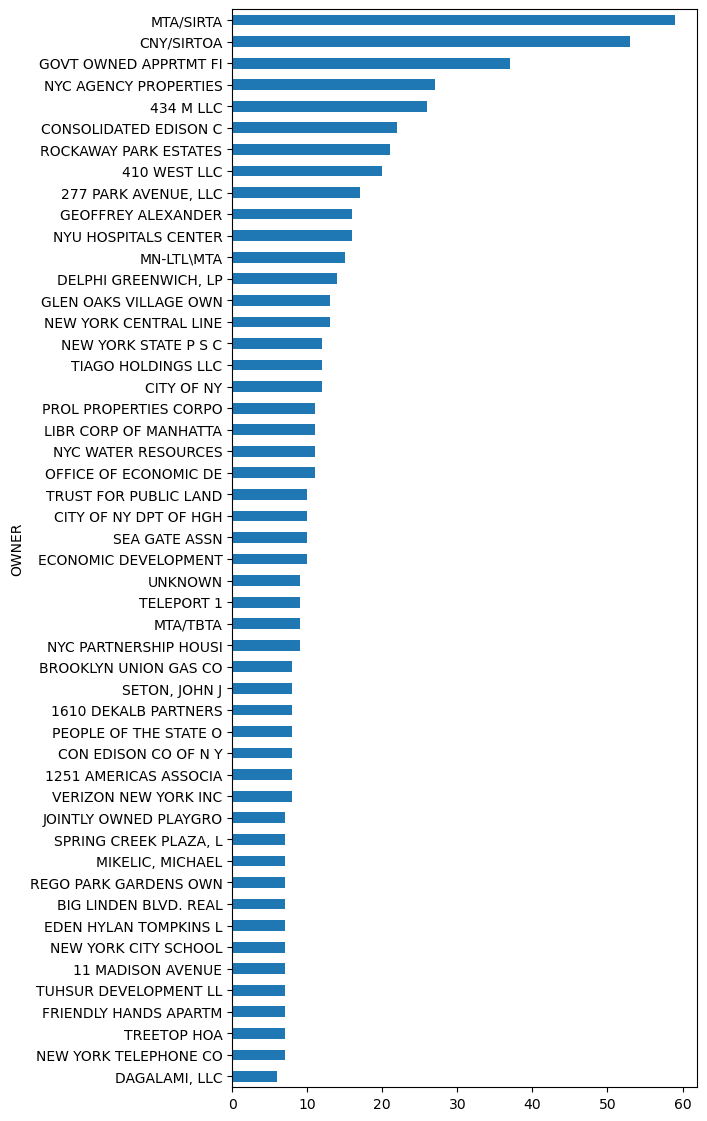

In [131]:
# you can look at this list and add some to the exclusions if you want
plt.figure(figsize=(6,14))
NY_data_top_n['OWNER'].value_counts().head(50).sort_values().plot(kind='barh')

In [132]:
NY_data_top_n.shape

(10000, 63)

In [133]:
# Write out some data sets that you can use for examination.
# Sometimes we want to ignore the ones with zero sizes since they're somewhat trivial cases.
NY_data_top_n.to_excel('NY_top_with_zs.xlsx', index=True)
NY_top_lotsize_ne_0 = NY_data_top_n[NY_data_top_n['LTFRONT'] != 0]
NY_top_lotsize_ne_0.to_excel('NY_top_lotsize_ne_0.xlsx', index=True)
NY_top_sizes_ne_0 = NY_top_lotsize_ne_0[NY_top_lotsize_ne_0['BLDDEPTH'] != 0]
NY_top_sizes_ne_0.to_excel('NY_top_sizes_ne_0.xlsx', index=True)

In [134]:
nfields = 34
data_base_vars = NY_data_top_n.iloc[:,nfields:nfields+9]
data_base_vars.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9
RECORD,,,,,,,,,
917942,-0.082426,128.297458,276.861374,8.276290,999.957285,1018.529092,16.688653,983.508585,1014.170858
561383,-0.093334,88.490709,254.637267,0.080595,22.632781,30.743050,0.315018,24.451939,33.626160
1053832,-0.073933,6.935168,20.007424,0.127208,0.084358,0.120209,0.507323,0.028299,0.046203
151044,0.085466,570.816079,703.806269,0.351801,43.917052,25.561785,3.284346,157.727464,92.940547
398266,-0.095121,3.675691,10.250694,-0.063432,0.118890,0.161028,0.010209,0.044727,0.066212


In [135]:
data_all_vars = NY_data_top_n.iloc[:,nfields:]
data_all_vars.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r2_taxclass,r3_taxclass,r4_taxclass,r5_taxclass,r6_taxclass,r7_taxclass,r8_taxclass,r9_taxclass,value_ratio,size_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
917942,-0.082426,128.297458,276.861374,8.276290,999.957285,1018.529092,16.688653,983.508585,1014.170858,0.084078,...,14.890970,42.294588,4.555461,384.936473,632.107821,9.479407,351.349667,659.897578,12.040708,-0.029616
561383,-0.093334,88.490709,254.637267,0.080595,22.632781,30.743050,0.315018,24.451939,33.626160,-0.051717,...,10.266350,38.898361,-0.122604,8.695309,19.062997,0.031059,8.719918,21.865173,0.260499,-0.029616
1053832,-0.073933,6.935168,20.007424,0.127208,0.084358,0.120209,0.507323,0.028299,0.046203,-0.071542,...,643.107017,665.569626,2.296469,275.217647,254.119052,3.986276,198.742135,187.988239,0.073000,-0.029616
151044,0.085466,570.816079,703.806269,0.351801,43.917052,25.561785,3.284346,157.727464,92.940547,0.027438,...,66.301360,107.539139,0.032199,16.889127,15.847374,1.744499,56.333539,60.460560,0.181039,-0.029616
398266,-0.095121,3.675691,10.250694,-0.063432,0.118890,0.161028,0.010209,0.044727,0.066212,-0.060280,...,342.137331,341.483632,0.283983,379.418134,337.861706,0.601058,288.844189,263.489840,-0.084083,-0.029616


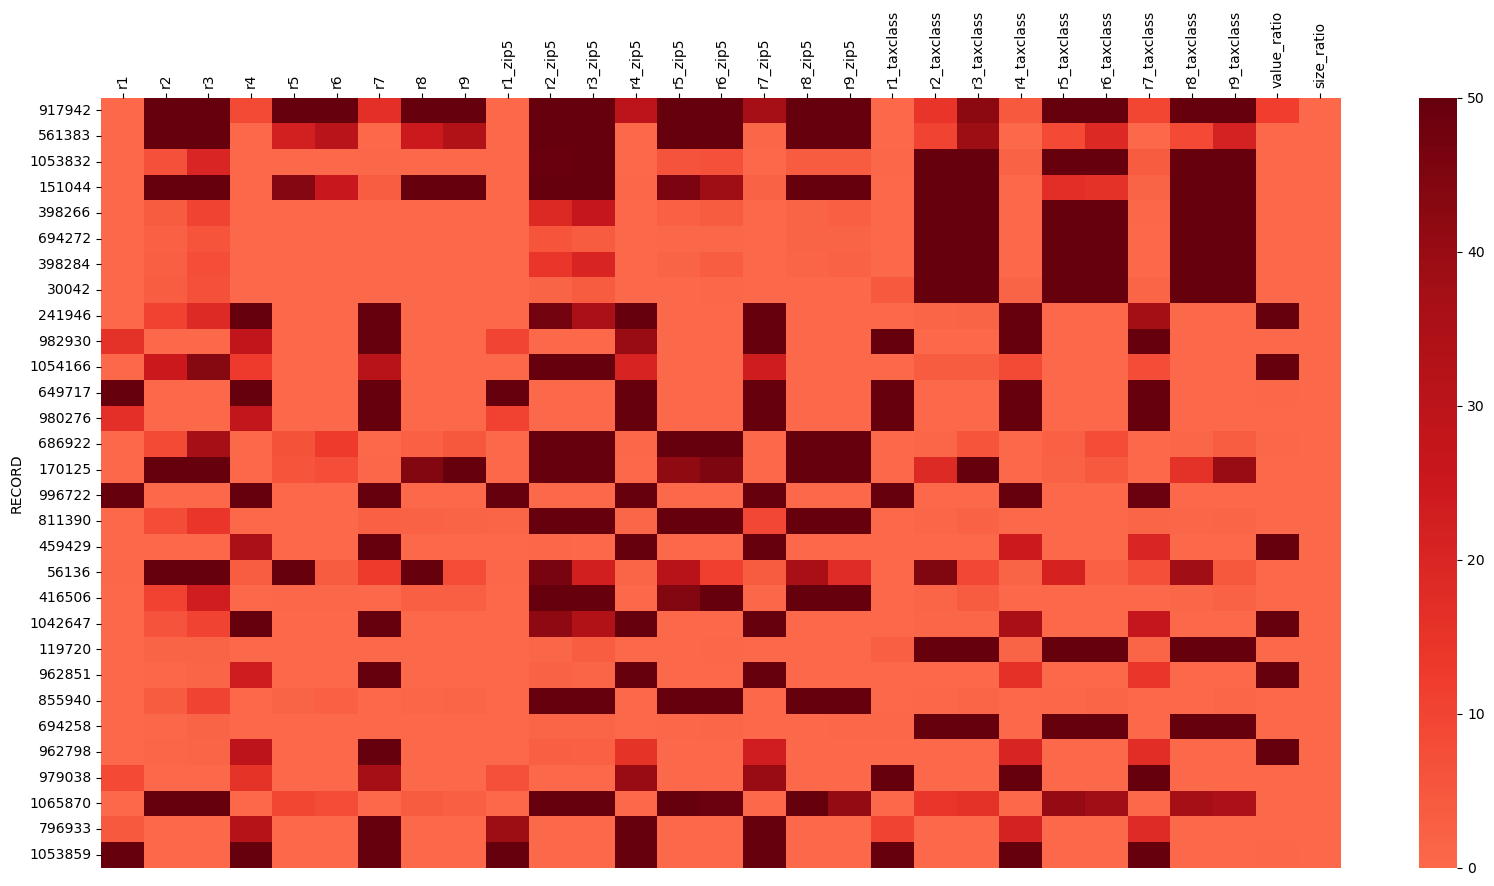

In [136]:
# The heatmaps are good for seeing which variables are driving the high scores
data_heatmap = data_all_vars.abs().head(30)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

In [137]:
top_records_df = pd.DataFrame(top_records)

In [138]:
# Use this cell if you want to write out the top n record numbers
# top_records_df.to_csv('top_n_record_numbers_baseline.csv', index=False)

In [139]:
# # Use this cell if you want to compare to a previous top n record numbers.
# # You can run a baseline model, see which records score the highest, then change some of the algorithm parameters
# # to see what % of these top scoring records change. The top records are insensitive to changes in the 
# # powers for the Minkowski distance measures for the two scores

# top_records_previous = pd.read_csv('top_n_record_numbers_baseline.csv')
# print(top_records_df.head())
# print(top_records_previous.head())
# num_common = len(pd.merge(top_records_df,top_records_previous, on='RECORD'))
# percent_common = 100*num_common/ntop
# percent_common

In [140]:
print('Duration: ', datetime.now() - start_time)

Duration:  0:01:07.444293


In [141]:
!pwd

/Users/pin/Downloads
